<a href="https://colab.research.google.com/github/JensH-2157843/AML_Project/blob/main/src/neural_networks/NN1(segmentation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library imports

In [ ]:
!pip install segmentation-models==1.0.1 albumentations==1.3.1 --quiet
import os
import numpy as np
from PIL import Image
from glob import glob
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from transformers import SegformerFeatureExtractor

import time
import copy
from torchvision import transforms

# Dataset import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## DATASET IMPORT ##
# import part was taken and modified from https://www.kaggle.com/code/ashrifrahmanarian/deepglobe-dubai-customunet
deepglobe_dir = "/content/drive/MyDrive/train"
import os

# Sort by labels
deepglobe_images = sorted(glob(os.path.join(deepglobe_dir, '*_sat.jpg')))
deepglobe_masks = sorted(glob(os.path.join(deepglobe_dir, '*_mask.png')))

for tile in sorted(os.listdir(deepglobe_dir)):
    tile_path = os.path.join(deepglobe_dir, tile)
    if not os.path.isdir(tile_path):
        continue
    img_folder = os.path.join(tile_path, "images")
    mask_folder = os.path.join(tile_path, "masks")
    deepglobe_images.extend(sorted(glob(os.path.join(img_folder, '*.jpg'))))
    deepglobe_masks.extend(sorted(glob(os.path.join(mask_folder, '*.png'))))

all_images = deepglobe_images
all_masks = deepglobe_masks

# divide in training and validation ser
train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    all_images, all_masks, test_size=0.2, random_state=42
)

In [ ]:
IMG_SIZE = (256, 256)

def rgb_to_binary_mask(mask_image, suitable_rgbs):
    mask = np.array(mask_image)
    binary_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int64)
    for rgb in suitable_rgbs:
        matches = np.all(mask == rgb, axis=-1)
        binary_mask[matches] = 1
    return binary_mask

image_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE, interpolation=transforms.InterpolationMode.NEAREST)
])

In [ ]:
 # I have defined a custom dataset that combines images and mask. I also defined the
 # transformation rules
class SolarPanelDataset(Dataset):
    def __init__(self, img_paths, mask_paths, suitable_rgbs, img_transform=None, mask_transform=None):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.suitable_rgbs = suitable_rgbs
        self.img_transform = img_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        # --- Start of Preprocessing Logic (PyTorch version) ---
        img_path = self.img_paths[idx]
        mask_path = self.mask_paths[idx]
        image = Image.open(img_path).convert("RGB")
        mask_rgb = Image.open(mask_path).convert("RGB")
        if self.img_transform:
            image = self.img_transform(image) # Applies resize, ToTensor, Normalize
        if self.mask_transform:
            mask_rgb = self.mask_transform(mask_rgb) # Applies resize (NEAREST)
        mask_binary = rgb_to_binary_mask(mask_rgb, self.suitable_rgbs) # Converts mask
        mask = torch.from_numpy(mask_binary) # To PyTorch Tensor
        # --- End of Preprocessing Logic ---
        return image, mask

In [ ]:
# RGB values for classes we consider 'Suitable' (Class 1)
SUITABLE_RGB_VALUES = [
    (255, 255, 0),  # Agriculture land
    (255, 0, 255),  # Rangeland
    (255, 255, 255),# Barren land
]
# The original dataset was divided into more labels. We add this new enum to preprocess the data for our specific problem

In [ ]:
val_loader = SolarPanelDataset(train_imgs, train_masks, SUITABLE_RGB_VALUES,  image_transforms, mask_transforms)
train_loader = SolarPanelDataset(val_imgs, val_masks, SUITABLE_RGB_VALUES,  image_transforms, mask_transforms)
# use data loader pytorch to create the batches
val_loader = DataLoader(val_loader, batch_size=20, shuffle=False)
train_loader = DataLoader(train_loader, batch_size=20, shuffle=True)

# Model 1(deprecated, we have used pretrained one since it's the best)

## Model

In [ ]:
## ARCHITECTURE ##
class ConvBlock(nn.Module):
    ## This module has
    ## (conv2d --> batchNorm --> ReLU) * 2
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        return x

class EncoderBlock(nn.Module):
    ## encoder Block: ConvBlock -> MaxPool
    ## returns both ConvBlock output (skip) and MaxPool output.
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        skip = self.conv_block(x)
        pooled = self.pool(skip)
        return skip, pooled

class DecoderBlock(nn.Module):
    # ConvTranspose -> Concat -> ConvBlock
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        # Upsamples by a factor of 2
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        # Here should be double --> convBlock takes skip + upconv
        # so input channels should be skip + upconv (I hope).
        self.conv_block = ConvBlock(out_channels * 2, out_channels)

    def forward(self, x, skip_connection):
        x = self.upconv(x)

        # Ensure spatial dimensions match before concatenating.
        # If input sizes are powers of 2, they should match.
        if x.shape != skip_connection.shape:

            diffY = skip_connection.size()[2] - x.size()[2]
            diffX = skip_connection.size()[3] - x.size()[3]
            skip_connection = skip_connection[:, :, diffY // 2 : skip_connection.size()[2] - diffY // 2 - diffY % 2,
                                                diffX // 2 : skip_connection.size()[3] - diffX // 2 - diffX % 2]

        x = torch.cat([x, skip_connection], dim=1) # Concatenate along channel dimension (dim=1)
        x = self.conv_block(x)
        return x

class DeepUnet(nn.Module):

    def __init__(self, in_channels=3, out_classes=2):
        ## in_channels = 3 RGB images
        ## out_classes: 1 --> suitable, 0 ---> not suitable
        super(DeepUnet, self).__init__()
        self.in_channels = in_channels
        self.out_classes = out_classes

        # sncoder
        self.enc1 = EncoderBlock(in_channels, 64)
        self.enc2 = EncoderBlock(64, 128)
        self.enc3 = EncoderBlock(128, 256)
        self.enc4 = EncoderBlock(256, 512)

        # latent space
        self.bottleneck = ConvBlock(512, 1024)

        # decoder module
        self.dec1 = DecoderBlock(1024, 512)
        self.dec2 = DecoderBlock(512, 256)
        self.dec3 = DecoderBlock(256, 128)
        self.dec4 = DecoderBlock(128, 64)

        # output layer
        self.output_conv = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        #
        s1, p1 = self.enc1(x)
        s2, p2 = self.enc2(p1)
        s3, p3 = self.enc3(p2)
        s4, p4 = self.enc4(p3)

        # latent space
        b1 = self.bottleneck(p4)

        # Decoder path
        d1 = self.dec1(b1, s4)
        d2 = self.dec2(d1, s3)
        d3 = self.dec3(d2, s2)
        d4 = self.dec4(d3, s1)

        # Output
        outputs = self.output_conv(d4)

        return outputs

## Learning algorithm

In [ ]:
# --- Configuration & Constants ---
IMG_SIZE = (256, 256)
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50
IN_CHANNELS = 3
OUT_CLASSES = 2 # 0: Not Suitable, 1: Suitable
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# EarlyStopping
EARLY_STOPPING_PATIENCE = 7
EARLY_STOPPING_MIN_DELTA = 0.0001

# model, loss, optimizer
print("Setting up model, loss, and optimizer...")
model = DeepUnet(in_channels=IN_CHANNELS, out_classes=OUT_CLASSES).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# training loop
print("Starting training...")
history = {'train_loss': [], 'val_loss': []}
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_weights = copy.deepcopy(model.state_dict()) # Store best model

for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    model.train()
    running_train_loss = 0.0
    for i, (images, masks) in enumerate(train_loader):
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        if (i + 1) % 20 == 0: # print every epoch
             print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i+1}/{len(train_loader)}], Batch Loss: {loss.item():.4f}")

    avg_train_loss = running_train_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)

    # validation part
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, masks)
            running_val_loss += loss.item()
    avg_val_loss = running_val_loss / len(val_loader)
    history['val_loss'].append(avg_val_loss)
    epoch_time = time.time() - start_time

    print(f"--- Epoch {epoch+1}/{NUM_EPOCHS} Finished ---")
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    print(f"Epoch Duration: {epoch_time:.2f} seconds")

    # EarlyStopping module. In pytorch i have to define it, not already defined like TensorFlow
    # https://docs.pytorch.org/ignite/generated/ignite.handlers.early_stopping.EarlyStopping.html
    if avg_val_loss < best_val_loss - EARLY_STOPPING_MIN_DELTA:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_weights = copy.deepcopy(model.state_dict())
        print(f"Validation loss improved. Saving model weights.")
    else:
        epochs_no_improve += 1
        print(f"Validation loss did not improve for {epochs_no_improve} epochs.")

    if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        # After it i have to restore the best wwights of the module
        model.load_state_dict(best_model_weights)
        break
    print("-" * 30)

print("Training finished!")
if epoch < NUM_EPOCHS -1 and epochs_no_improve < EARLY_STOPPING_PATIENCE :
    print("Completed all epochs.")
    model.load_state_dict(best_model_weights)

# print all History for debugging
print("\n--- Training History ---")
for i in range(len(history['train_loss'])):
    print(f"Epoch {i+1}: Train Loss = {history['train_loss'][i]:.4f}, Val Loss = {history['val_loss'][i]:.4f}")

Setting up model, loss, and optimizer...
Starting training...
--- Epoch 1/50 Finished ---
Train Loss: 0.6500 | Val Loss: 0.6679
Epoch Duration: 173.12 seconds
Validation loss improved. Saving model weights.
------------------------------
--- Epoch 2/50 Finished ---
Train Loss: 0.6087 | Val Loss: 0.6020
Epoch Duration: 160.55 seconds
Validation loss improved. Saving model weights.
------------------------------
--- Epoch 3/50 Finished ---
Train Loss: 0.5256 | Val Loss: 0.5496
Epoch Duration: 162.01 seconds
Validation loss improved. Saving model weights.
------------------------------
--- Epoch 4/50 Finished ---
Train Loss: 0.5219 | Val Loss: 0.5652
Epoch Duration: 162.47 seconds
Validation loss did not improve for 1 epoch(s).
------------------------------
--- Epoch 5/50 Finished ---
Train Loss: 0.4767 | Val Loss: 0.5864
Epoch Duration: 159.91 seconds
Validation loss did not improve for 2 epoch(s).
------------------------------
--- Epoch 6/50 Finished ---
Train Loss: 0.4996 | Val Loss:

In [ ]:
# save module to give to heatmap module
# Architecture has also the module, while weights just have the parameteres --> to import it copy the module here

torch.save(model, "model_with_architecture.pth")
torch.save(model.state_dict(), "model_weights.pth")

In [ ]:
def predict(model_instance, input_image_tensor):
    model_instance.eval()
    with torch.no_grad():
        raw_output = model_instance(input_image_tensor)

    predicted_mask = torch.argmax(raw_output, dim=1)
    return predicted_mask, raw_output


# Access the underlying dataset from the DataLoader
val_dataset = val_loader.dataset

# Choose an index for the image you want to predict on (e.g., index 5)
image_index = 5

# Get the image and mask at that index from the dataset
# The result will be (image_tensor, mask_tensor)
single_image, single_mask = val_dataset[image_index]

# The predict function expects a batch, so add a batch dimension (N=1)
# Move the image tensor to the appropriate device
input_image_for_prediction = single_image.unsqueeze(0).to(DEVICE)

predicted_mask, raw_output = predict(model_1, input_image_for_prediction)

print(f"Predicted Mask Shape: {predicted_mask.shape}")
print(f"Raw Output Shape: {raw_output.shape}")

Predicted Mask Shape: torch.Size([1, 256, 256])
Raw Output Shape: torch.Size([1, 2, 256, 256])


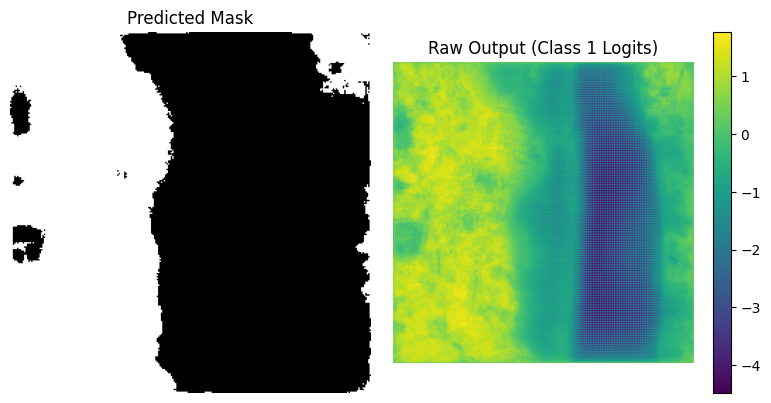

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Assuming predicted_mask and raw_output are already computed PyTorch tensors
# predicted_mask has shape (N, H, W) where N is batch size (usually 1 for single image)
# raw_output has shape (N, out_classes, H, W)

# Convert predicted_mask to NumPy array and remove batch dimension if N=1
predicted_mask_np = predicted_mask.squeeze(0).cpu().numpy()

# raw_output contains logits for each class. For visualization, you might
# want to look at the logits for a specific class or the argmax.
# Let's visualize the argmax (which is essentially the predicted_mask)
# or optionally, the logits for one of the classes.
# For simplicity, let's visualize the predicted mask again and perhaps
# the probabilities for one class if you apply softmax.

# If you want to visualize the predicted mask
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(predicted_mask_np, cmap='gray') # Use a colormap appropriate for masks
plt.title("Predicted Mask")
plt.axis('off')

# If you want to visualize the raw output for a specific class (e.g., class 1)
# This shows the 'confidence' of the model for that class before argmax.
# Remember to handle the batch dimension and move to CPU.
if raw_output.shape[1] > 1: # Check if there's more than one class output
    raw_output_class1_np = raw_output.squeeze(0)[1].cpu().numpy() # Assuming class 1 is at index 1
    plt.subplot(1, 2, 2)
    plt.imshow(raw_output_class1_np, cmap='viridis') # Or another suitable colormap
    plt.title("Raw Output (Class 1 Logits)")
    plt.colorbar() # Add a color bar to see the range of logits
    plt.axis('off')
else:
    # If only one output channel, it might represent the probability of the positive class (if using sigmoid)
    # or just logits for binary classification (if using CrossEntropyLoss with 2 classes).
    # Let's assume it's logits for the positive class for visualization.
    if raw_output.shape[1] == 1:
        raw_output_single_channel_np = raw_output.squeeze(0).squeeze(0).cpu().numpy()
        plt.subplot(1, 2, 2)
        plt.imshow(raw_output_single_channel_np, cmap='viridis')
        plt.title("Raw Output Logits")
        plt.colorbar()
        plt.axis('off')


plt.tight_layout()
plt.show()

# Pretained one

In [ ]:
## Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision.models.segmentation import deeplabv3_resnet50, fcn_resnet50
import copy
import time

In [ ]:
# hyperparameters
IMG_SIZE = (256, 256)
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50 # I can also try to reduce it, to speed up the training. Drawbacks of doing it seems not relevant
IN_CHANNELS = 3
OUT_CLASSES = 2  # 0: Not Suitable, 1: Suitable
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# transfer learning config.
FREEZE_ENCODER = True  # I start with freeze ResNet parameters
UNFREEZE_AFTER_EPOCHS = 10  # when to unfreeze the network. I can play more with this hyperparameters, but be careful---> GPU is not illimitate!
PRETRAINED_LR_FACTOR = 0.1  # learning rate for ResNet50

# early stop
EARLY_STOPPING_PATIENCE = 7
EARLY_STOPPING_MIN_DELTA = 0.0001

In [ ]:

class PretrainedEncoderUNet(nn.Module):
    # U-Net with pretrained encoder (ResNet backbone)
    def __init__(self, in_channels=3, out_classes=2, pretrained=True):
        super(PretrainedEncoderUNet, self).__init__()

        # ResNet50
        resnet = models.resnet50(pretrained=pretrained)
        # I remove the final layers (avgpool and fc). I just need the last feature map
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])

        # feature dimensions for ResNet50
        encoder_dims = [64, 256, 512, 1024, 2048]

        # decoder blocks
        self.decoder5 = self._make_decoder_block(2048, 1024)
        self.decoder4 = self._make_decoder_block(1024 + 1024, 512)  # +1024 from skip connection
        self.decoder3 = self._make_decoder_block(512 + 512, 256)   # +512
        self.decoder2 = self._make_decoder_block(256 + 256, 128)   # +256
        self.decoder1 = self._make_decoder_block(128 + 64, 64)     # +64

        # Final output layer
        self.final_conv = nn.Conv2d(64, out_classes, kernel_size=1)

        # encoder layer for skip connections
        self.encoder_layers = self._get_encoder_layers(resnet)

    def _make_decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def _get_encoder_layers(self, resnet):
        layers = {}
        layers['conv1'] = resnet.conv1
        layers['bn1'] = resnet.bn1
        layers['relu'] = resnet.relu
        layers['maxpool'] = resnet.maxpool
        layers['layer1'] = resnet.layer1
        layers['layer2'] = resnet.layer2
        layers['layer3'] = resnet.layer3
        layers['layer4'] = resnet.layer4
        return layers

    def forward(self, x):
        # Encoder path with skip connections
        # Initial conv block
        x1 = self.encoder_layers['conv1'](x)
        x1 = self.encoder_layers['bn1'](x1)
        x1 = self.encoder_layers['relu'](x1)
        skip1 = x1  # 64 channels

        x2 = self.encoder_layers['maxpool'](x1)
        x2 = self.encoder_layers['layer1'](x2)
        skip2 = x2  # 256 channels

        x3 = self.encoder_layers['layer2'](x2)
        skip3 = x3  # 512 channels

        x4 = self.encoder_layers['layer3'](x3)
        skip4 = x4  # 1024 channels

        x5 = self.encoder_layers['layer4'](x4)

        # decoder
        d5 = self.decoder5(x5)
        d4 = torch.cat([d5, skip4], dim=1)
        d4 = self.decoder4(d4)

        d3 = torch.cat([d4, skip3], dim=1)
        d3 = self.decoder3(d3)

        d2 = torch.cat([d3, skip2], dim=1)
        d2 = self.decoder2(d2)

        d1 = torch.cat([d2, skip1], dim=1)
        d1 = self.decoder1(d1)

        output = self.final_conv(d1)

        return output

    # this fuctions allows to freeze/unfreeze the nn when i want. Change UNFREEZE_AFTER_EPOCHS to do that. Now is 10 epochs
    def freeze_encoder(self):
        for name, param in self.named_parameters():
            if 'encoder' in name:
                param.requires_grad = False # When the grad is false the nn is not learning
        print("Encoder layers frozen")

    def unfreeze_encoder(self):
        for name, param in self.named_parameters():
            if 'encoder' in name:
                param.requires_grad = True
        print("Encoder layers unfrozen")

## This was another experiment. Not used for the final report
class DeepLabTransferUNet(nn.Module):
    def __init__(self, out_classes=2):
        super(DeepLabTransferUNet, self).__init__()

        # DeepLabV3
        self.backbone = deeplabv3_resnet50(pretrained=True)

        # classifier
        self.backbone.classifier = nn.Sequential(
            nn.Conv2d(2048, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Conv2d(256, out_classes, kernel_size=1)
        )

    def forward(self, x):
        return self.backbone(x)['out']

    def freeze_backbone(self):
        for name, param in self.named_parameters():
            if 'classifier' not in name:
                param.requires_grad = False
        print("Backbone frozen, only classifier trainable")

    def unfreeze_backbone(self):
        for param in self.parameters():
            param.requires_grad = True
        print("All layers unfrozen")

# transfer learninf setup. Just modify model_type to use which one you want. If i have time, i can also try other backbones
def setup_transfer_learning_model(model_type="pretrained_unet"):
    """
    Setup model with transfer learning
    """
    if model_type == "pretrained_unet":
        model = PretrainedEncoderUNet(
            in_channels=IN_CHANNELS,
            out_classes=OUT_CLASSES,
            pretrained=True
        ).to(DEVICE)

        if FREEZE_ENCODER:
            model.freeze_encoder()

    elif model_type == "deeplab":
        model = DeepLabTransferUNet(out_classes=OUT_CLASSES).to(DEVICE)
        if FREEZE_ENCODER:
            model.freeze_backbone()

    return model

# the encoder and the decoder has different optimizer and different learning rate.
# In general, in pretrained i should reduce the learning step so reduce the lr
def setup_optimizer(model, model_type="pretrained_unet"):

    if model_type == "pretrained_unet":
        # Different learning rates for encoder and decoder
        encoder_params = []
        decoder_params = []

        for name, param in model.named_parameters():
            if param.requires_grad:
                if 'encoder' in name:
                    encoder_params.append(param)
                else:
                    decoder_params.append(param)

        optimizer = optim.Adam([
            {'params': encoder_params, 'lr': LEARNING_RATE * PRETRAINED_LR_FACTOR},
            {'params': decoder_params, 'lr': LEARNING_RATE}
        ])

    else:
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    return optimizer

# training function
def train_with_transfer_learning(model, train_loader, val_loader, model_type="pretrained_unet"):
    # It is a binary classification task --> so cross entropy
    criterion = nn.CrossEntropyLoss()
    optimizer = setup_optimizer(model, model_type)

    # I add a scheduler to improve the learning
    # https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )

    print("Starting transfer learning training...")
    history = {'train_loss': [], 'val_loss': [], 'lr': []}
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_weights = copy.deepcopy(model.state_dict())

    for epoch in range(NUM_EPOCHS):
        start_time = time.time()

        # logic: when epoch is 10 and encoder is freezed(True) ---> unfreeze
        if epoch == UNFREEZE_AFTER_EPOCHS and FREEZE_ENCODER:
            if model_type == "pretrained_unet":
                model.unfreeze_encoder()
            elif model_type == "deeplab":
                model.unfreeze_backbone()

            # Recreate optimizer with unfrozen parameters
            optimizer = setup_optimizer(model, model_type)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='min', factor=0.5, patience=5, verbose=True
            )

        model.train()
        running_train_loss = 0.0

        for i, (images, masks) in enumerate(train_loader):
            # remeber: everything should be on the same device!!!
            images, masks = images.to(DEVICE), masks.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)

            # Handle different output formats. I had a strange error. Gemini suggest this change and works
            if isinstance(outputs, dict):
                outputs = outputs['out']

            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

            if (i + 1) % 20 == 0:
                print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i+1}/{len(train_loader)}], "
                      f"Batch Loss: {loss.item():.4f}")

        avg_train_loss = running_train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(DEVICE), masks.to(DEVICE)
                outputs = model(images)

                if isinstance(outputs, dict):
                    outputs = outputs['out']

                loss = criterion(outputs, masks)
                running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)

        # I have to update the learning rate using scheduler.step
        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        history['lr'].append(current_lr)

        epoch_time = time.time() - start_time

        print(f"--- Epoch {epoch+1}/{NUM_EPOCHS} Finished ---")
        print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        print(f"Learning Rate: {current_lr:.6f}")
        print(f"Epoch Duration: {epoch_time:.2f} seconds")

        # early stop module
        if avg_val_loss < best_val_loss - EARLY_STOPPING_MIN_DELTA:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            best_model_weights = copy.deepcopy(model.state_dict())
            print("Validation loss improved. Saving model weights.")
        else:
            epochs_no_improve += 1
            print(f"Validation loss did not improve for {epochs_no_improve} epoch(s).")

        if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            model.load_state_dict(best_model_weights)
            break

        print("-" * 50)

    print("Training finished!")
    model.load_state_dict(best_model_weights)
    return model, history

if __name__ == "__main__":
    # model setup
    MODEL_TYPE = "pretrained_unet"
    model = setup_transfer_learning_model(MODEL_TYPE)

    print(f"Model type: {MODEL_TYPE}")

    # trained model
    trained_model, history = train_with_transfer_learning(model, train_loader, val_loader, MODEL_TYPE)

    # training history. I print this after training
    print("\n--- Transfer Learning Training History ---")
    for i in range(len(history['train_loss'])):
         print(f"Epoch {i+1}: Train Loss = {history['train_loss'][i]:.4f}, "
               f"Val Loss = {history['val_loss'][i]:.4f}, LR = {history['lr'][i]:.6f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Encoder layers frozen
Model type: pretrained_unet
Total parameters: 50,033,474
Trainable parameters: 26,525,442
Starting transfer learning training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


--- Epoch 1/50 Finished ---
Train Loss: 0.6611 | Val Loss: 0.7222
Learning Rate: 0.000010
Epoch Duration: 298.29 seconds
Validation loss improved. Saving model weights.
--------------------------------------------------
--- Epoch 2/50 Finished ---
Train Loss: 0.5452 | Val Loss: 0.7377
Learning Rate: 0.000010
Epoch Duration: 158.02 seconds
Validation loss did not improve for 1 epoch(s).
--------------------------------------------------
--- Epoch 3/50 Finished ---
Train Loss: 0.4636 | Val Loss: 0.7352
Learning Rate: 0.000010
Epoch Duration: 159.97 seconds
Validation loss did not improve for 2 epoch(s).
--------------------------------------------------
--- Epoch 4/50 Finished ---
Train Loss: 0.4205 | Val Loss: 0.3837
Learning Rate: 0.000010
Epoch Duration: 158.21 seconds
Validation loss improved. Saving model weights.
--------------------------------------------------
--- Epoch 5/50 Finished ---
Train Loss: 0.4284 | Val Loss: 0.3590
Learning Rate: 0.000010
Epoch Duration: 154.38 seconds

KeyboardInterrupt: 

KeyboardInterrupt: 

## evaluation part

In [ ]:
def evaluate_binary_multiclass(model, dataloader, device='cuda'):
    model.eval()
    total_conf = {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)  # [B, C, H, W]
            masks = masks.to(device)    # [B, H, W] with values 0 or 1

            outputs = model(images)     # [B, 2, H, W]
            preds = torch.argmax(outputs, dim=1)  # [B, H, W]

            TP = torch.sum((preds == 1) & (masks == 1)).item()
            TN = torch.sum((preds == 0) & (masks == 0)).item()
            FP = torch.sum((preds == 1) & (masks == 0)).item()
            FN = torch.sum((preds == 0) & (masks == 1)).item()

            total_conf['TP'] += TP
            total_conf['TN'] += TN
            total_conf['FP'] += FP
            total_conf['FN'] += FN

    # Compute metrics
    TP, TN, FP, FN = total_conf['TP'], total_conf['TN'], total_conf['FP'], total_conf['FN']
    eps = 1e-7

    accuracy = (TP + TN) / (TP + TN + FP + FN + eps)
    precision = TP / (TP + FP + eps)
    recall = TP / (TP + FN + eps)
    specificity = TN / (TN + FP + eps)
    f1_score = 2 * precision * recall / (precision + recall + eps)
    iou = TP / (TP + FP + FN + eps)

    print("\n Binary Segmentation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1 Score: {f1_score:.4f}")
    print(f"IoU: {iou:.4f}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1_score': f1_score,
        'iou': iou
    }

In [ ]:
model = torch.load("model_with_architecture.pth", weights_only=False)

metrics = evaluate_binary_multiclass(model, val_loader, device='cuda')